In [1]:
import pandas as pd
df = pd.read_csv('bitcoinTwitterPolarity.csv', parse_dates=['timestamp'], dayfirst=True)
print(df.columns.values)

['Unnamed: 0' 'id' 'priceopen' 'priceclose' 'pricechange' 'timestamp'
 'tweetid' 'tweetcreatedate' 'tweetlang' 'tweettext' 'polarity']


In [2]:
datag = df[['priceclose','polarity']].groupby(df['timestamp']).mean()

from sklearn.preprocessing import MinMaxScaler

values = datag['priceclose'].values.reshape(-1,1)
sentiment = datag['polarity'].values.reshape(-1,1)
values = values.astype('float32')
sentiment = sentiment.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

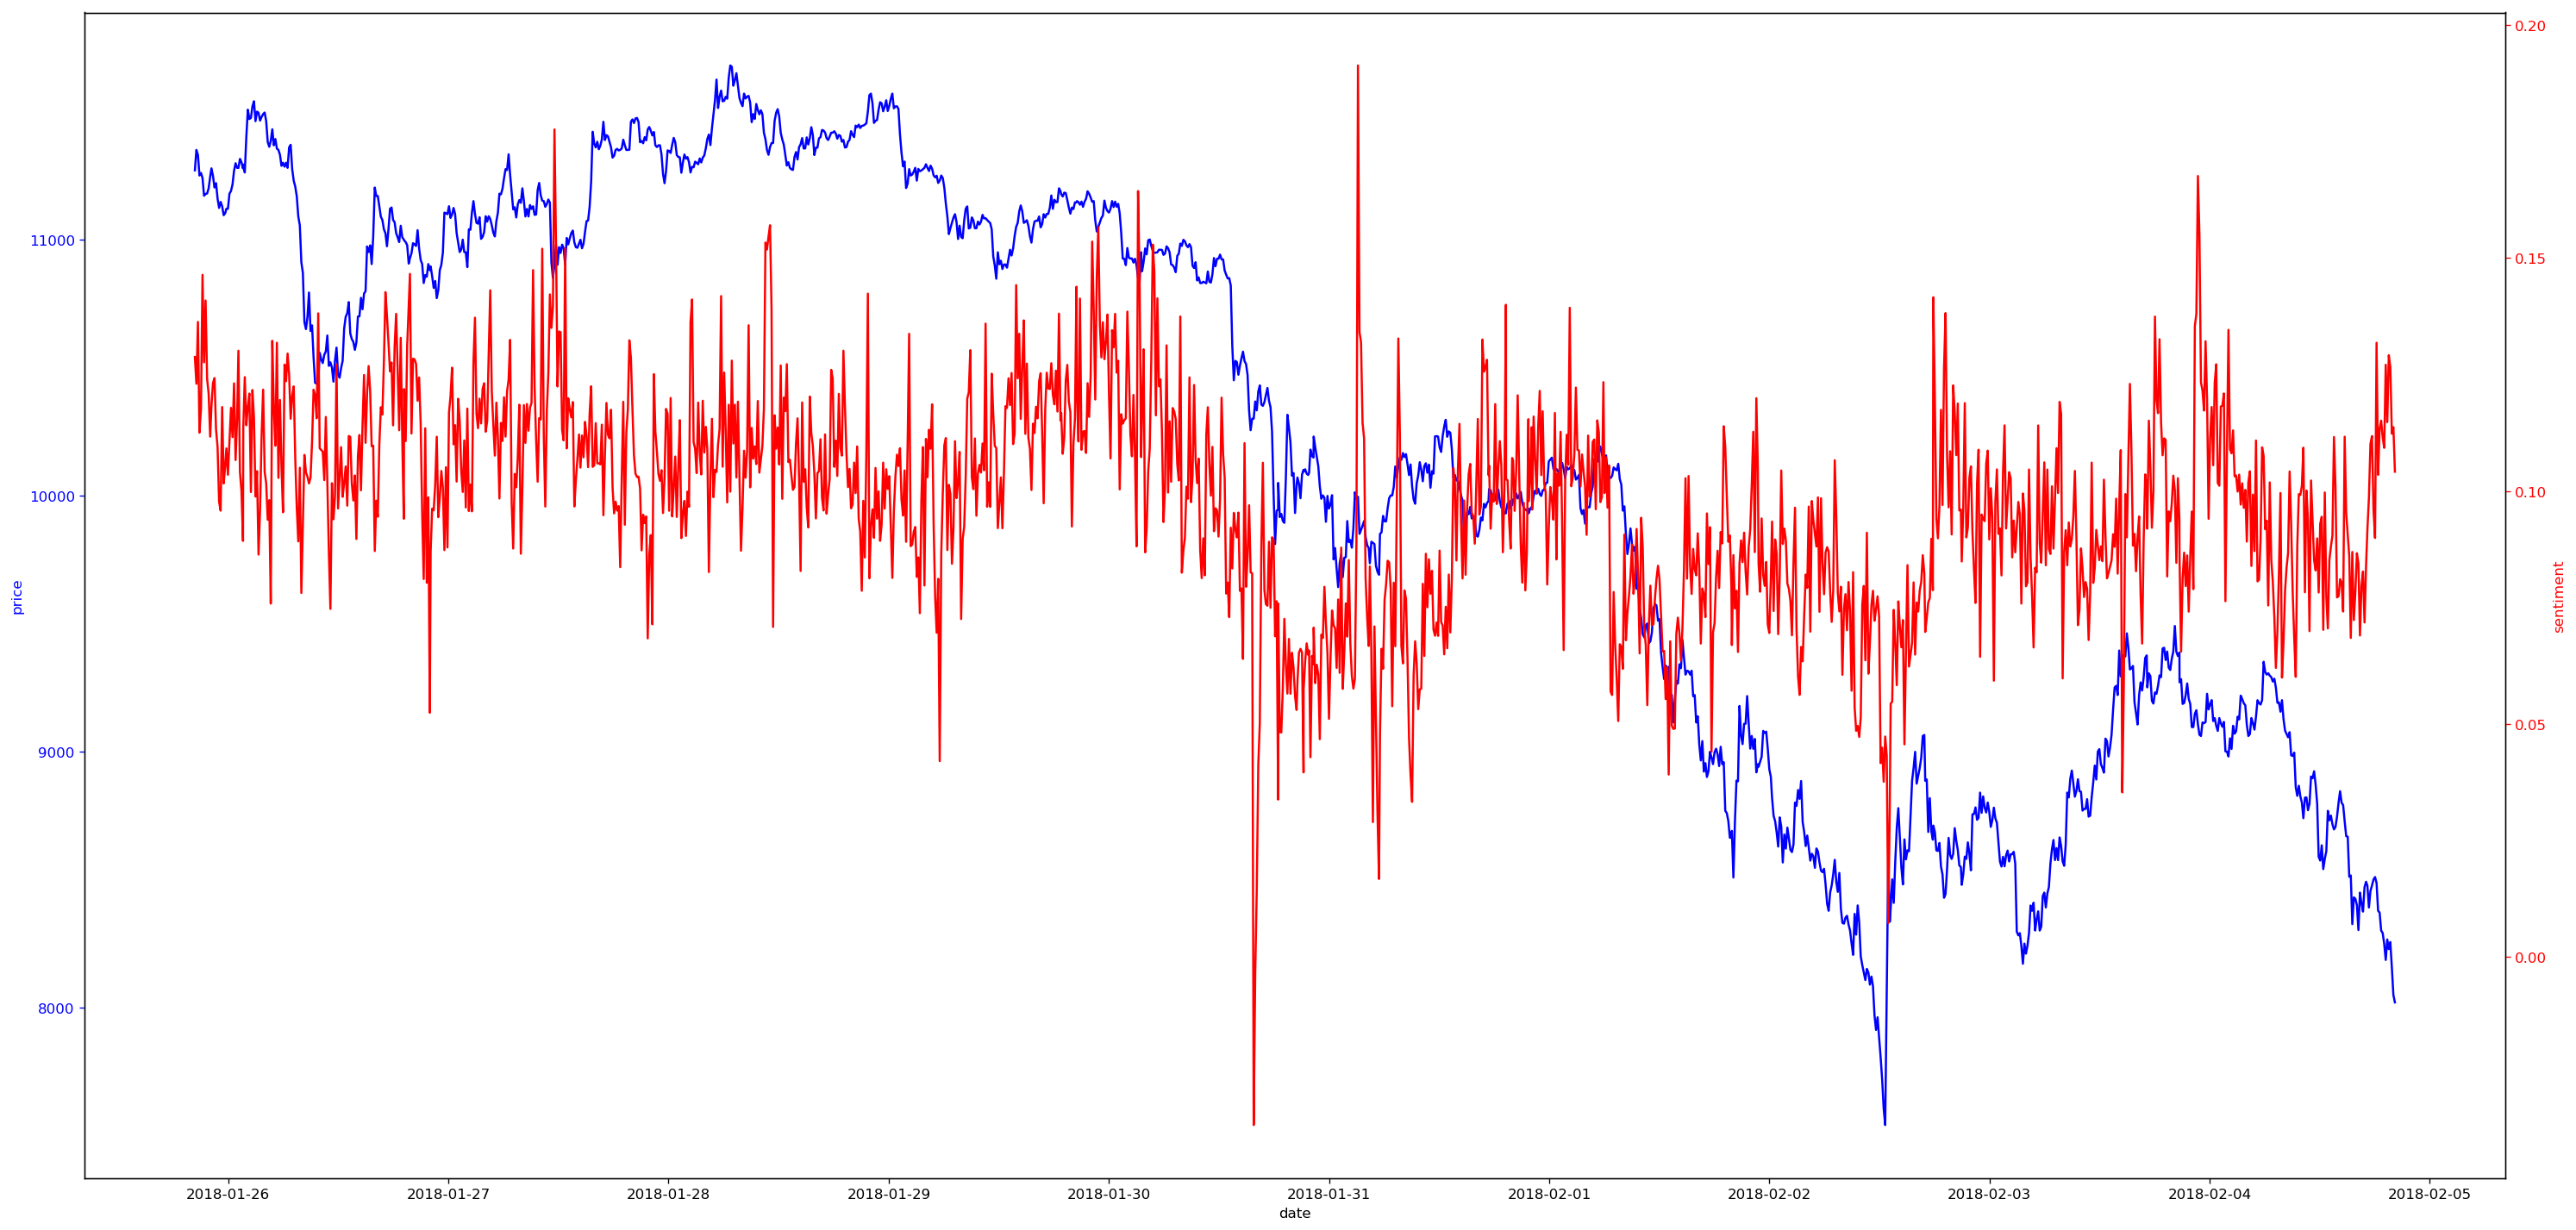

In [58]:
%matplotlib inline
#%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(25, 12), dpi= 120, facecolor='w', edgecolor='k')

xAxisData = df['timestamp'].unique()
y1AxisData = df[['priceclose']].groupby(df['timestamp']).mean()
y2AxisData = df[['polarity']].groupby(df['timestamp']).mean()

ax1.plot(xAxisData, y1AxisData, 'b-')
ax1.set_xlabel('date')
ax1.set_ylabel('price', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
# - creates a line . creates only points when appended to the color code
ax2.plot(xAxisData, y2AxisData, 'r-')
ax2.set_ylabel('sentiment', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

In [48]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))
split = train_size

1020 438


In [49]:
import numpy as np

def create_dataset(dataset, look_back, sentiment, sent=False):
    dataX, dataY = [], []
    
    print(range(len(dataset) - look_back))
    
    for i in range(len(dataset) - look_back):
        if i >= look_back:
            a = dataset[i-look_back:i+1, 0]
            a = a.tolist()
            if(sent==True):
                a.append(sentiment[i].tolist()[0])
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
    #print(len(dataY))
    return np.array(dataX), np.array(dataY)

look_back = 2
trainX, trainY = create_dataset(train, look_back, sentiment[0:train_size],sent=True)
testX, testY = create_dataset(test, look_back, sentiment[train_size:len(scaled)], sent=True)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

range(0, 1018)
range(0, 436)


In [80]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(500, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(500))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=1000, batch_size=1000, validation_data=(testX, testY), verbose=0, shuffle=False)

yhat = model.predict(testX)

(434, 1)
(434, 1)


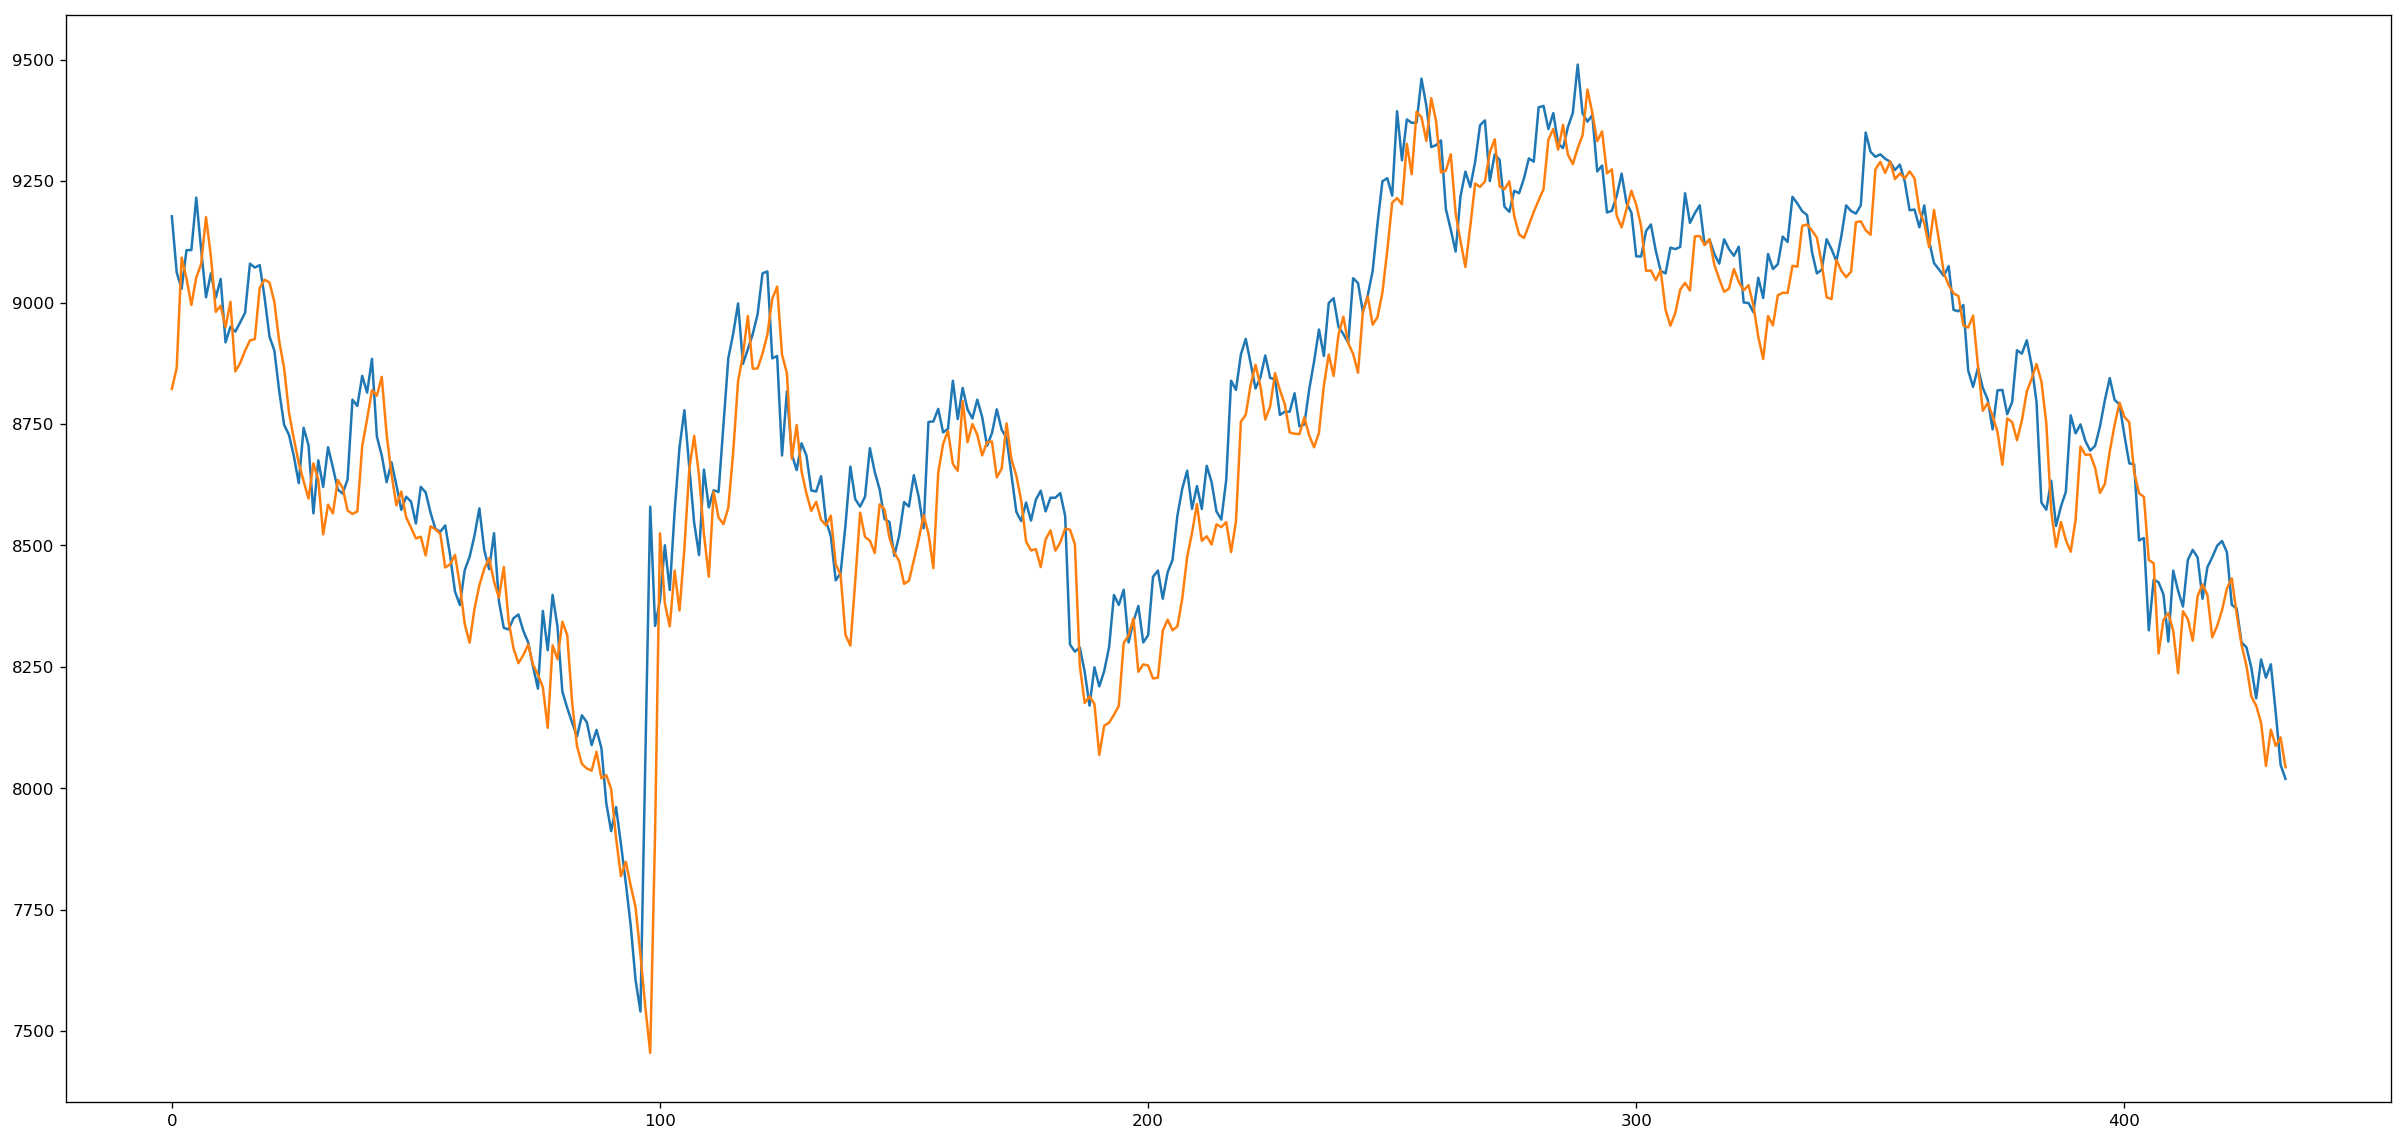

In [81]:
predictedPrices = scaler.inverse_transform(yhat)
actualPrices = scaler.inverse_transform(test)[4:test.shape[0]]

fig=plt.figure(figsize=(25, 12), dpi= 120, facecolor='w', edgecolor='k')

plt.plot(actualPrices)
plt.plot(predictedPrices)

plt.show()

In [82]:
from math import sqrt
from sklearn.metrics import mean_squared_error

yhat_inverse_sent = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse_sent = scaler.inverse_transform(testY.reshape(-1, 1))

rmse_sent = sqrt(mean_squared_error(testY_inverse_sent, yhat_inverse_sent))
print('Test RMSE: %.3f' % rmse_sent)

Test RMSE: 127.893
